In [1]:
#Automated reloading of custom modules
%load_ext autoreload
%autoreload 2

In [2]:
#Standard modules
import os
import time
import numpy as np
import scipy
import torch
import torch.nn as nn
from torch.utils.data import random_split, DataLoader, Dataset
import matplotlib.pyplot as plt
from datetime import datetime

#Custom modules
import helpers as hlp
import models as mdl

# Check avaibale device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Used device: {}.".format(DEVICE))

Used device: cpu.


### Reproductability

In [3]:
SEED = 12345
torch.manual_seed(SEED)
np.random.seed(SEED)

### Parameters

In [4]:
#Dataset
DATASET = "MNIST" 
MODEL = "lenet5" # 'fc', 'resnet18', 'lenet5'
REDUCED = True
FLATTEN = True if MODEL == "fc" else False

#Learning
BATCH_SIZE = 16
EPOCHS = 100
ROUNDS = 1000
BATCH_SIZE_KD = 16
EPOCHS_PER_ROUND_KD = 1
RANDOM_SAMPLES = 1000
CRITERION = nn.CrossEntropyLoss()
CRITERION_KD = nn.MSELoss() #loss for knowledge diffusion
N_EVAL = 1 #Evaluate train and test performace after N_EVAL epochs

#Directories
DATE = datetime.now()
EXPORT_DIR = "./saves/RandomKD/" + DATE.strftime("%d-%m-%Y/%H-%M-%S")
os.makedirs(EXPORT_DIR, exist_ok=True)

# Store parameters
with open(EXPORT_DIR + "/metadata.txt", 'w') as f:
    f.write("Parameter of the experiment conducted the {} at {}.\n\n".format(DATE.strftime("%d/%m/%Y"),
                                                                         DATE.strftime("%H:%m:%Y")))
    f.write("Model architecture:       {}\n".format(MODEL))
    f.write("Dataset:                  {}\n".format(DATASET))
    f.write("Reduced:                  {}\n".format(REDUCED))
    f.write("Epoch (Teacher):          {}\n".format(EPOCHS))
    f.write("Batch size (Teacher):     {}\n".format(BATCH_SIZE))
    f.write("Criterion (Teacher):      {}\n".format(type(CRITERION)))
    f.write("Number of random samples: {}\n".format(RANDOM_SAMPLES))
    f.write("Rounds (KD):              {}\n".format(ROUNDS))
    f.write("Epoch per round (KD):     {}\n".format(EPOCHS_PER_ROUND_KD))
    f.write("Batch size (KD):          {}\n".format(BATCH_SIZE_KD))
    f.write("Criterion (KD):           {}\n".format(type(CRITERION_KD)))
    f.write("Seed:                     {}\n".format(SEED))

### Data loadiing

In [5]:
# Load dataset
train_input, train_target, val_input, val_target, meta = hlp.load_data(dataset=DATASET,
                                                                       reduced=REDUCED, 
                                                                       flatten=FLATTEN,
                                                                       device=DEVICE)

#Create custom torch datasets
train_ds = hlp.ImageDataset(train_input, train_target)
val_ds = hlp.ImageDataset(val_input, val_target)

#Create dataloader
train_dl = hlp.ds_to_dl(train_ds, batch_size=BATCH_SIZE)
val_dl = hlp.ds_to_dl(val_ds)

** Using MNIST **
Load train data...
Load validation data...
Dataset sizes:
	- Train: (1000, 1, 28, 28)
	- Validation (300, 1, 28, 28)


### Teacher model

In [6]:
# Model initialization
m_teacher = mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE)

# Performance tracker
pt_teacher = hlp.PerfTracker(m_teacher, train_dl, val_dl, CRITERION, 
                             meta["n_class"], EXPORT_DIR + "/teacher", , ID="Student")


In [7]:
# Initialization
optimizer = torch.optim.Adam(m_teacher.parameters())
m_teacher.train()

#Teacher learning
for e in range(EPOCHS):
    t0 = time.time()
    for features, target in train_dl:
        optimizer.zero_grad()
        output = m_teacher(features)
        loss = CRITERION(output, target)
        loss.backward()
        optimizer.step()

    #Tracking performance
    if e % N_EVAL == 0:
        pt_teacher.new_eval(index=e)
    print("\rEpoch {}/{} done.".format(e+1, EPOCHS), end="  ")


Epoch 100/100 done.  

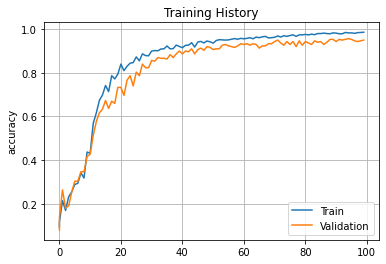

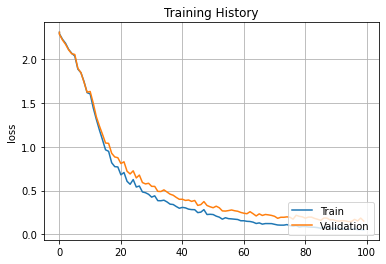

In [8]:
# Visualization of training history
pt_teacher.plot_training_history(metric="accuracy")
pt_teacher.plot_training_history(metric="loss")

### Student model (KD)

In [ ]:
# Student model and performance tracker initialization
m_student = mdl.LeNet5(meta["in_dimension"][0], meta["n_class"]).to(DEVICE)
pt_student = hlp.PerfTracker(m_student, train_dl, val_dl, CRITERION, 
                             meta["n_class"], EXPORT_DIR + "/student", ID="Student")

In [14]:
#Knowledge distillation
for r in range(ROUNDS):
    # Blind learning (creation of input/output pairs)
    X = torch.normal(0, 1, size=(RANDOM_SAMPLES, *meta["in_dimension"])).to(DEVICE)    
    m_teacher.eval()
    with torch.no_grad():
        Y = m_teacher(X)
    
    ds_kd = hlp.ImageDataset(X, Y)
    dl_kd = hlp.ds_to_dl(ds_kd, batch_size=BATCH_SIZE_KD)
    
    # Blind learning (knowledge diffusion)
    optimizer = torch.optim.Adam(m_student.parameters())
    #model.train() #Should this be? maybe the dropout hinders the effect of KD
    
    for e in range(EPOCHS_PER_ROUND_KD):
        for x_kd, y_kd in dl_kd:
            optimizer.zero_grad()
            y_kd_pers = m_student(x_kd)
            loss = CRITERION_KD(y_kd_pers, y_kd)
            loss.backward()
            optimizer.step()
        #Tracking performance
        if r % N_EVAL == 0:
            pt_student.new_eval(index=r)
    print("\rRound {}/{}: KD done.".format(r+1, ROUNDS), end=40*" ")

Round 1000/1000: KD done.                                        

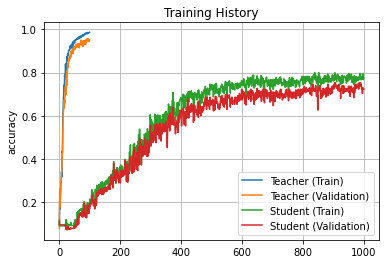

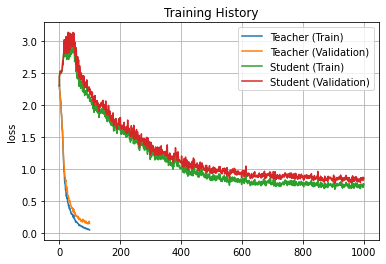

In [60]:
# Comparison of training history
hlp.plot_global_training_history([pt_teacher, pt_student], "accuracy", savepath=EXPORT_DIR + "/accuracy.png")
hlp.plot_global_training_history([pt_teacher, pt_student], "loss", savepath=EXPORT_DIR + "/loss.png")

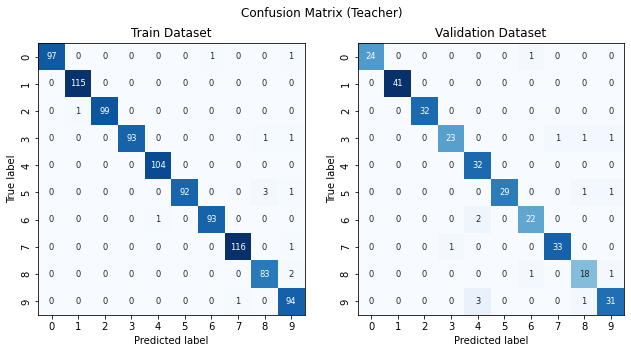

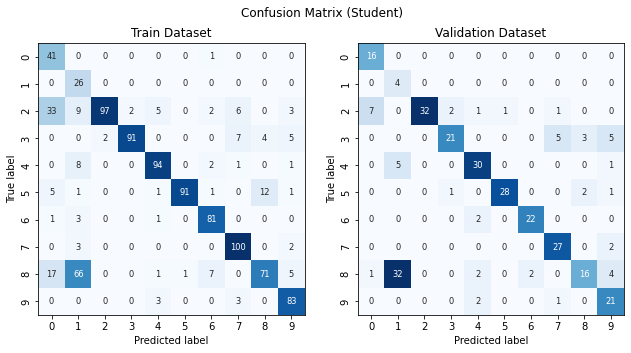

In [111]:
# Ccnfusion matrices
pt_teacher.plot_confusion_matrix(savepath=EXPORT_DIR + "/CM_teacher.png")
pt_student.plot_confusion_matrix(savepath=EXPORT_DIR + "/CM_student.png")